<a href="https://colab.research.google.com/github/karaage0703/covid19_memo/blob/master/signate_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 新型コロナウイルスの感染状況を分析するためのノートブック

データを可視化するために、個人的に作成しているものです。

内容の正確性を保証するものではありませんので、ご注意下さい。


以下リポジトリでPR受付中です。

https://github.com/karaage0703/covid19_memo

## データのダウンロード
SIGNATEのCOVID-19チャレンジ（フェーズ1）で作成されたオープンデータ（Google Spread Sheet)を用いて分析

https://signate.jp/competitions/260

In [1]:
!wget --no-check-certificate --output-document=data.csv 'https://docs.google.com/spreadsheets/d/1CnQOf6eN18Kw5Q6ScE_9tFoyddk4FBwFZqZpt_tMOm4/export?gid=0&format=csv'

--2020-04-04 15:37:17--  https://docs.google.com/spreadsheets/d/1CnQOf6eN18Kw5Q6ScE_9tFoyddk4FBwFZqZpt_tMOm4/export?gid=0&format=csv
Resolving docs.google.com (docs.google.com)... 74.125.195.113, 74.125.195.139, 74.125.195.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data.csv’

data.csv                [ <=>                ]   1.26M  --.-KB/s    in 0.1s    

2020-04-04 15:37:18 (9.45 MB/s) - ‘data.csv’ saved [1320269]



## 死亡率と性別の関係

SIGNATEのフォーラムの以下の分析例を、Google Colaboratoryで動作するように改変

https://signate.jp/competitions/261/discussions/20200401125031-59

データをpandasを使って読み込み、内容を確認する

In [0]:
import pandas as pd

# SIGNATE COVID-2019 Dataset からデータを読み込み、ステータスと性別を抽出
df = pd.read_csv("data.csv")
df = df[["ステータス","性別"]]

# ステータスのフラグを変換
df["ステータス"] = df["ステータス"].replace({0: '罹患中', 1: '回復', 2: '死亡'})

f = lambda x: '{:.2%}'.format(x)

ステータス別の人数と割合

In [3]:
status_cnt = df["ステータス"].value_counts()
status_ratio = df["ステータス"].value_counts(normalize=True).apply(f) 

status_table = pd.concat([status_cnt, status_ratio], axis=1)
status_table.columns= ["人数","割合(%)"]
status_table

,人数,割合(%)
罹患中,2154,91.97%
回復,163,6.96%
死亡,25,1.07%


性別の人数と割合

In [4]:
gender_cnt = df["性別"].value_counts()
gender_ratio = df["性別"].value_counts(normalize=True).apply(f)
 
gender_table = pd.concat([gender_cnt, gender_ratio],  axis=1)
gender_table.columns= ["人数","割合"]
gender_table

,人数,割合
男性,1359,58.10%
女性,971,41.51%
非公表,9,0.38%


性別による死亡率の違い

In [5]:
df["ステータス"] = df["ステータス"].replace({'罹患中': '生存', "回復": '生存', 2: '死亡'})
ct = pd.crosstab(df["性別"],df["ステータス"])
ct

ステータス,死亡,生存
性別,,
女性,6,951
男性,17,1316
非公表,1,8


In [6]:
print("死亡における男性の割合：{:.0%}".format(ct.loc["男性","死亡"]/ct.loc[:,"死亡"].sum()))

死亡における男性の割合：71%


p値の確認

In [7]:
# Fisher's exact test
import scipy.stats as st
_, p = st.fisher_exact(ct[0:2])
print(f'p値 = {p :.3f}')

p値 = 0.141


## Bar Chart Race

以下discussionを参考に都道府県別の累積罹患者数推移をBar Chart Raceを使って可視化
https://signate.jp/competitions/261/discussions/20200401171320-59

matplotlibの日本語化

https://karaage.hatenadiary.jp/entry/2018/12/17/073000

In [8]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 4.7MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=9979457dbbd79f6905de9e4bf3e9108027ecddcb7942facef361d25c450c0006
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib


In [9]:
import japanize_matplotlib

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [0]:
import pandas as pd
import datetime

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
#import seaborn as sns
#sns.set(font='Yu Gothic', style='white')
#mpl.rcParams['font.family'] = 'YuGothic'

In [0]:
pref_area = {
    "北海道":"北海道",
    "青森県":"東北",
    "岩手県":"東北",
    "宮城県":"東北",
    "秋田県":"東北",
    "山形県":"東北",
    "福島県":"東北",
    "茨城県":"北関東・甲信",
    "栃木県":"北関東・甲信",
    "群馬県":"北関東・甲信",
    "埼玉県":"南関東",
    "千葉県":"南関東",
    "東京都":"南関東",
    "神奈川県":"南関東",
    "新潟県":"北陸",
    "富山県":"北陸",
    "石川県":"北陸",
    "福井県":"北陸",
    "山梨県":"北関東・甲信",
    "長野県":"北関東・甲信",
    "岐阜県":"東海",
    "静岡県":"東海",
    "愛知県":"東海",
    "三重県":"東海",
    "滋賀県":"近畿",
    "京都府":"近畿",
    "大阪府":"近畿",
    "兵庫県":"近畿",
    "奈良県":"近畿",
    "和歌山県":"近畿",
    "鳥取県":"中国",
    "島根県":"中国",
    "岡山県":"中国",
    "広島県":"中国",
    "山口県":"中国",
    "徳島県":"四国",
    "香川県":"四国",
    "愛媛県":"四国",
    "高知県":"四国",
    "福岡県":"九州",
    "佐賀県":"九州",
    "長崎県":"九州",
    "熊本県":"九州",
    "大分県":"九州",
    "宮崎県":"九州",
    "鹿児島県":"九州",
    "沖縄県":"九州"
}

colors = {
    "北海道":'#7db0dd',
    "東北":'#8bade0',
    "北陸":'#99a9e2',
    "北関東・甲信":'#a6a6e2',
    "南関東":'#b1a2e1',
    "東海":'#c59cdc',
    "近畿":'#d497d3',
    "中国":'#de94c6',
    "四国":'#e393b6',
    "九州":'#e495a5'
}

データ整形

In [13]:
# SIGNATE COVID-2019 Dataset をダウンロードして【罹患者】のみをCSVファイルとして用意しておく
# 用意したCSVファイルをpd.DataFrameとして読み込む
df = pd.read_csv('data.csv')
df.shape

(2462, 27)

In [14]:
# 列の絞り込み
df = df.loc[:, ['公表日', '受診都道府県']]
# 公表日か受診都道府県のいずれかが欠損している記録は除外
df.dropna(how='any', inplace=True)
# 公表日をdatetime64型に変換
df['公表日'] = pd.to_datetime(df['公表日'], format='%Y/%m/%d')
# 都道府県フラグ列を追加
df = pd.concat([df, pd.get_dummies(df['受診都道府県'])], axis=1)
df.set_index('公表日', inplace=True)

df.tail()

,受診都道府県,三重県,京都府,佐賀県,兵庫県,北海道,千葉県,和歌山県,埼玉県,大分県,大阪府,奈良県,宮城県,宮崎県,富山県,山口県,山形県,山梨県,岐阜県,岡山県,広島県,徳島県,愛媛県,愛知県,新潟県,東京都,栃木県,沖縄県,滋賀県,熊本県,石川県,神奈川県,福井県,福岡県,福島県,秋田県,群馬県,茨城県,長崎県,長野県,青森県,静岡県,香川県,高知県,鹿児島県
公表日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-24,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-26,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-28,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-28,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-30,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# 日毎の罹患者公表数を集計
df_count = df.resample('D').sum()
df_count.tail()

,三重県,京都府,佐賀県,兵庫県,北海道,千葉県,和歌山県,埼玉県,大分県,大阪府,奈良県,宮城県,宮崎県,富山県,山口県,山形県,山梨県,岐阜県,岡山県,広島県,徳島県,愛媛県,愛知県,新潟県,東京都,栃木県,沖縄県,滋賀県,熊本県,石川県,神奈川県,福井県,福岡県,福島県,秋田県,群馬県,茨城県,長崎県,長野県,青森県,静岡県,香川県,高知県,鹿児島県
公表日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-31,0,0,1,11,0,8,0,1,1,28,0,1,0,1,0,1,0,0,0,0,0,5,8,0,78,2,0,0,0,2,0,5,17,2,1,2,4,0,0,0,0,0,2,0
2020-04-01,0,0,1,14,5,1,0,0,0,34,0,4,0,2,0,1,3,0,1,0,0,0,5,0,66,3,0,0,1,2,0,1,32,2,1,0,18,3,0,0,0,0,3,1
2020-04-02,0,0,0,7,3,0,0,0,1,33,0,1,0,4,0,1,0,0,2,4,0,2,0,0,0,0,0,0,0,0,0,0,22,2,0,0,2,3,0,1,0,0,1,1
2020-04-03,0,0,0,0,5,0,0,0,0,35,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,1,0,0,10,0,0,2,0,0,0,0
2020-04-04,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0


In [16]:
# 日毎の罹患者公表数を累積として集計
df_cumsum = df_count.cumsum()
df_cumsum.tail()

,三重県,京都府,佐賀県,兵庫県,北海道,千葉県,和歌山県,埼玉県,大分県,大阪府,奈良県,宮城県,宮崎県,富山県,山口県,山形県,山梨県,岐阜県,岡山県,広島県,徳島県,愛媛県,愛知県,新潟県,東京都,栃木県,沖縄県,滋賀県,熊本県,石川県,神奈川県,福井県,福岡県,福島県,秋田県,群馬県,茨城県,長崎県,長野県,青森県,静岡県,香川県,高知県,鹿児島県
公表日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-31,10,56,2,148,178,124,18,88,29,244,11,8,3,2,5,1,5,21,4,6,3,9,178,31,522,14,10,6,14,12,126,20,46,4,6,20,23,2,7,8,8,2,17,1
2020-04-01,10,56,3,162,183,125,18,88,29,278,11,12,3,4,5,2,8,21,5,6,3,9,183,31,588,17,10,6,15,14,126,21,78,6,7,20,41,5,7,8,8,2,20,2
2020-04-02,10,56,3,169,186,125,18,88,30,311,11,13,3,8,5,3,8,21,7,10,3,11,183,31,588,17,10,6,15,14,126,21,100,8,7,20,43,8,7,9,8,2,21,3
2020-04-03,10,56,3,169,191,125,18,88,30,346,11,19,3,8,5,3,8,21,7,10,3,11,183,31,588,17,10,6,15,14,126,21,119,9,7,20,53,8,7,11,8,2,21,3
2020-04-04,10,56,3,169,191,125,18,88,30,346,11,20,3,8,5,3,8,21,7,10,3,11,183,31,588,17,10,6,15,14,126,21,119,14,7,20,53,8,7,11,8,2,21,3


In [0]:
# 累積罹患者公表数の多い10都道府県を日毎に集計
patient_report = {}
for _, se in df_cumsum.iterrows():
    patient_report[se.name.date()] = se.sort_values(ascending=False).head(10)

In [18]:
# 例）2020/03/20時点の累積罹患者を表示
patient_report[datetime.date(2020, 3, 20)]

北海道     157
愛知県     139
東京都     129
大阪府     123
兵庫県     101
神奈川県     70
埼玉県      45
千葉県      43
新潟県      25
京都府      23
Name: 2020-03-20 00:00:00, dtype: uint64

可視化

In [0]:
# Bar Chart Race描画用の関数の作成
def draw_barchart(date):
    data = patient_report[date].sort_values()
    ax.clear()
    ax.barh(data.index, data.values, color=[colors[pref_area[x]] for x in data.index])
    
    for i, (name, value) in enumerate(zip(data.index, data.values)):
        area = pref_area[name]
        ax.text(value, i, name, size=14, weight=600, ha='right', va='bottom')
        ax.text(value, i-.25, area, size=10, color='#444444', ha='right', va='baseline')
        ax.text(value, i, value, size=14, ha='left',  va='bottom')

    ax.text(1, 0.4, data.name.date(), transform=ax.transAxes,color='#777777', size=38, ha='right', weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    plt.xlim(0, 600)
    plt.box(False)

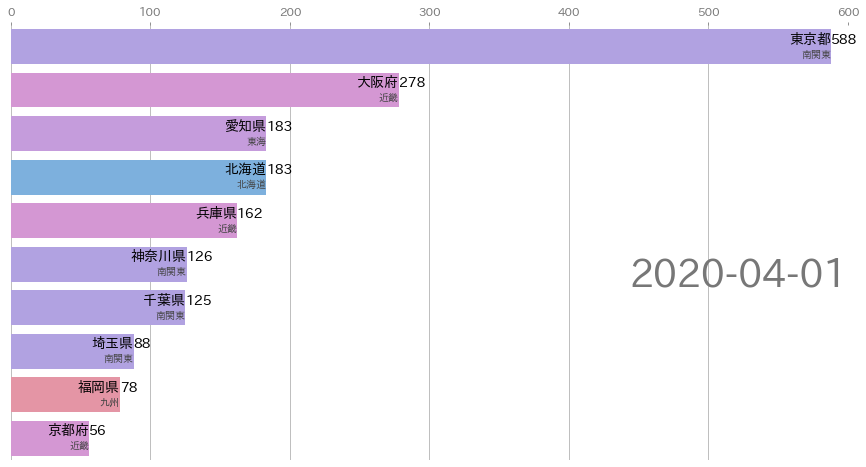

In [20]:
# 例）2020/03/20時点の累積罹患者を表示
fig, ax = plt.subplots(figsize=(15, 8))
draw_barchart(datetime.date(2020, 4, 1))

アニメGIFを作成するためにimagemagickをインストール

参考：https://qiita.com/shinmura0/items/ed96863281637e4fa10c

In [21]:
!apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

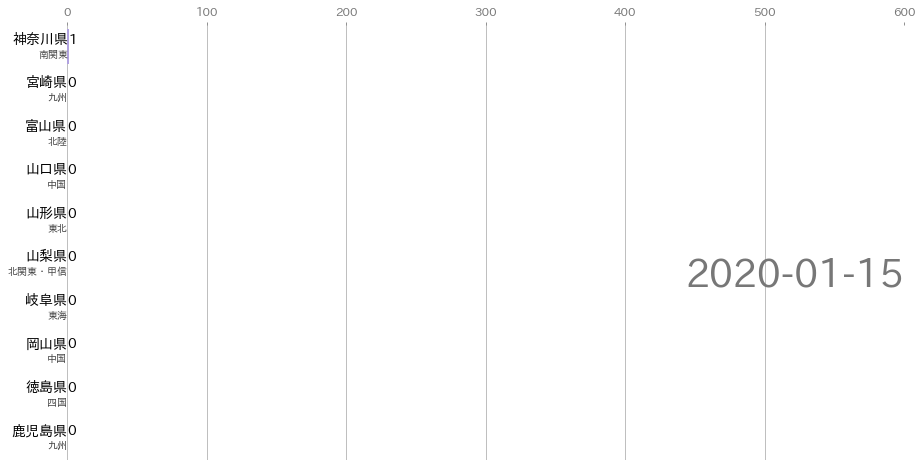

In [22]:
# 罹患者推移をgifファイルとして保存
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=list(patient_report.keys()))
animator.save('output.gif', writer="imagemagick")

In [0]:
from google.colab import files
files.download('output.gif')

# References